# Oja's Learning Rule

This is a first foray into unsupervised learning rules. After coming across Oja's learning rule (Oja, 1982), I was quite intrigued as to how a model neuron could implement principal component analysis (PCA).

## Part 1: Theory of Oja's Rule

The first part of this notebook is more or less a regurgitation of Oja (2008) with some extra details added to quickly check some aspects that are given without proof on Scholarpedia.

$\textbf{Note.}$  Must add assumption that input data has zero mean and variance one.

Suppose we have a model neuron that takes as input N-dimensional vectors $\textbf{x} = [x_1, ..., x_N]^T \in \mathbb{R}^N$. We have some data which is a finite set of input vectors $X \subset \mathbb{R}^N$. Given an input $\textbf{x} \in X$ and a weight vector $\textbf{w} = [w_1, ..., w_N]^T \in \mathbb{R}^N$ we calculate the activation (or firing rate) of our neuron as the standard inner product in $\mathbb{R}^N$

$$ r^{out} := \sum_{i=1}^{N} w_i x_i = \textbf{w}^T \textbf{x} .$$

Oja's learning rule then says that the neuron should adjust its weight vector according to the differential equation

$$ \frac {d \textbf{w}}{dt} = \eta r^{out} (\textbf{x} - r^{out}\textbf{w}).$$

With some simple algebra we see that a fixed point of this differential equation is 

\begin{align}
\frac {d \textbf{w}}{dt} &= \eta r^{out} (\textbf{x} - r^{out} \textbf{w})\\
       &= \eta [(\textbf{w}^T \textbf{x}) \textbf{x} - (\textbf{w}^T \textbf{x})^2 \textbf{w}]\\
       &= \eta [(\textbf{x}^T \textbf{w}) \textbf{x} - (\textbf{w}^T \textbf{x})(\textbf{x}^T \textbf{w})\textbf{w}]\\
       &= \eta [\textbf{x}(\textbf{x}^T \textbf{w}) - (\textbf{w}^T \textbf{x})(\textbf{x}^T \textbf{w})\textbf{w}]\\
       &= \eta [(\textbf{x}\textbf{x}^T) \textbf{w} - (\textbf{w}^T \textbf{x}\textbf{x}^T \textbf{w})\textbf{w}]\\
       &= 0.
\end{align}

And so we have

$$ (\textbf{x}\textbf{x}^T) \textbf{w} = (\textbf{w}^T \textbf{x}\textbf{x}^T \textbf{w})\textbf{w}$$

$\textbf{To do.}$ Prove this next stuff.

Covariance matrix C, averaging over $\textbf{x}\textbf{x}^T$

$$ C \textbf{w} = (\textbf{w}^T C \textbf{w})\textbf{w}$$

and clear that

$$ \lambda := \textbf{w}^T C \textbf{w} > 0$$ 

since C is positive semi-definite (due to the form $\textbf{x}\textbf{x}^T$).

So we see the above is simply the eigenvector-eignenvalue problem for the input data covariance matrix

$$ C \textbf{w} = \lambda \textbf{w}$$


## Part 2: Implementation of Oja's Rule in 2D

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import sys

### Create a 2D dataset

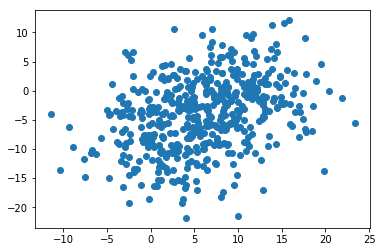

In [2]:
%matplotlib inline
# Random seed
np.random.seed(1)

# Create a dataset of Gaussian blobs
X, _ = make_blobs(n_samples=500, centers=2, cluster_std=5.0, random_state=1000)

# Plot the data
plt.scatter(X[:,0], X[:,1])
plt.show()

### Rescale

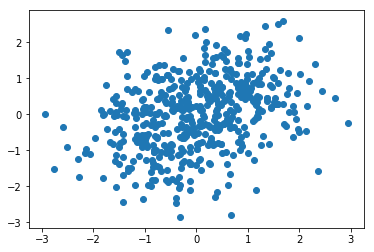

In [3]:
# Rescale to have zero mean and standard devation 1
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Plot the data
plt.scatter(Xs[:,0], Xs[:,1])
plt.show()

### Evolve neuron according to Oja's Rule

In [4]:
# Generate initial weights
W = np.random.normal(scale=0.25, size=(2,1))
W_prev = np.ones((2,1))

# learning rate and tolerance of change in weights
eps = 1e-5
tol = 1e-9

# this implementation is one-to-one from the Bonaccorso (2017)
# it is very straightforward
while np.linalg.norm(W - W_prev) > tol:
    W_prev = W.copy()
    Y = np.dot(Xs, W)
    W += eps * np.sum(Y*Xs - np.square(Y)*W.T, axis=0).reshape((2,1))

### Now compare results with eigenvector of covariance matrix (1st principal component)

In [5]:
C = np.cov(Xs.T)
eigval, eigvec = np.linalg.eig(C)

# show the eigenvector with maximum eigenvalue and the weight vector
print(eigvec[:, np.argmax(eigval)])
print(np.reshape(W, 2))

[-0.70710678 -0.70710678]
[ 0.70710699  0.70710657]


### Plot this vector through the data

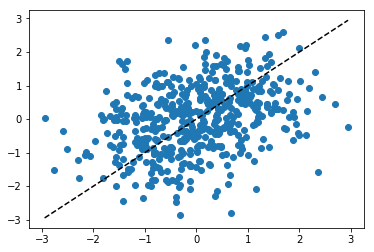

In [6]:
# Plot the data
plt.scatter(Xs[:,0], Xs[:,1])

# Plot the weight vector
xx = np.linspace(np.min(Xs), np.max(Xs), num=500)
plt.plot(xx, W[1]/W[0]*xx, '--k')
plt.show()

## Part 2: A note on (rate) coding

Having the weight vector, $w \in \mathbb{R}^n $, line up with the first principal component of the data is clever. Suppose the output of our neuron given by

$$ r^{out} (x) := w^T x $$

is the rate, $r_{out}$, at which the neuron fires to a particular stimulus, $x \in \mathbb{R}^n $. 

Notice technically we have a problem here since the rates can turn out to be negative... This is due to the fact that our input data is centered. Let's ignore this for now and deal with this later.

In the figure below, we can distinguish the two the yellow input vector, $x_1$, from the red input vector, $x_2$ since the dot product with the weight vector differs. Namely,

$$ r^{out} (x_1) = w^T x_1 > w^T x_2 = r^{out} (x_2) $$

and so we get different output rates depending on how well the input vector matches with the weight vector (i.e. the direction of greatest variance or first principal component of the data).

It is clear that having the weight vector aligned with the direction of maximal variance is the best we can do.

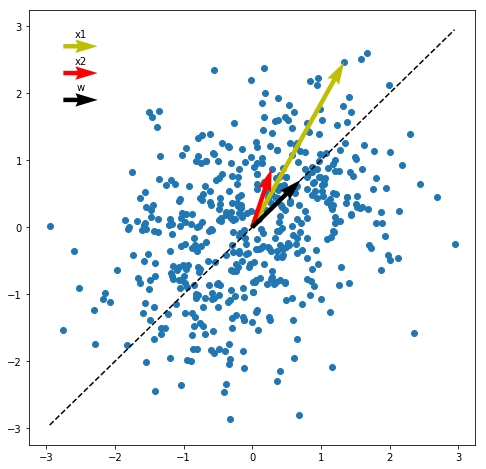

In [7]:
# Plot the data
plt.figure(figsize=(8,8))
plt.scatter(Xs[:,0], Xs[:,1])

# Plot a dashed line through the direction of greatest variance (direction of weight vector)
xx = np.linspace(np.min(Xs), np.max(Xs), num=500)
plt.plot(xx, W[1]/W[0]*xx, '--k')

# A couple of examples
x1 = 13
x2 = 1

# Plot the weight vector, and two data vectors
Q_x1 = plt.quiver([0], [0], Xs[x1, 0], Xs[x1, 1], color='y', width=.01, angles='xy', scale_units='xy', scale=1)
Q_x2 = plt.quiver([0], [0], Xs[x2, 0], Xs[x2, 1], color='r', width=.01, angles='xy', scale_units='xy', scale=1)
Q_W = plt.quiver([0], [0], W[0], W[1], color='k', width=.01, angles='xy', scale_units='xy', scale=1)

# Make a legend
plt.quiverkey(Q_x1, -2.5, 2.7, .5, 'x1', coordinates='data')
plt.quiverkey(Q_x2, -2.5, 2.3, .5, 'x2', coordinates='data')
plt.quiverkey(Q_W, -2.5, 1.9, .5, 'w', coordinates='data')

plt.show()

## Part 3: Implementation of Oja's Rule in 3-Dimensions

Of course this works exactly the same as above.

### Create a 3-dimensional dataset

In [8]:
N = 3
n_samples = 500
n_clouds = 2
centers = np.array([0, 15])

# Random seed
np.random.seed(1)

# Create a random data set made of two clouds of points in 3-space
X = np.zeros((n_samples, N))
X[0:int(n_samples/n_clouds), :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[0]
X[int(n_samples/n_clouds):, :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[1]

### Rescale

In [9]:
# Rescale to have zero mean and standard devation 1
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Evolve neuron according to Oja's Rule

In [10]:
# Generate initial weights
W = np.random.normal(scale=0.25, size=(N,1))
W_prev = np.ones((N,1))

# learning rate and tolerance of change in weights
eps = 1e-5
tol = 1e-9

# this implementation is one-to-one from the Bonaccorso (2017)
# it is very straightforward
while np.linalg.norm(W - W_prev) > tol:
    W_prev = W.copy()
    Y = np.dot(Xs, W)
    W += eps * np.sum(Y*Xs - np.square(Y)*W.T, axis=0).reshape((N,1))

### Now compare results with eigenvector of covariance matrix (1st principal component)

In [11]:
C = np.cov(Xs.T)
eigval, eigvec = np.linalg.eig(C)

# show the eigenvector with the largest eigenvalue and the weight vector
print(eigvec[:,np.argmax(eigval)])
print(np.reshape(W, N))

[ 0.59410822  0.5489531   0.58795061]
[ 0.59410833  0.54895295  0.58795064]


### Plot the principal axis given by the weight vector

<IPython.core.display.Javascript object>


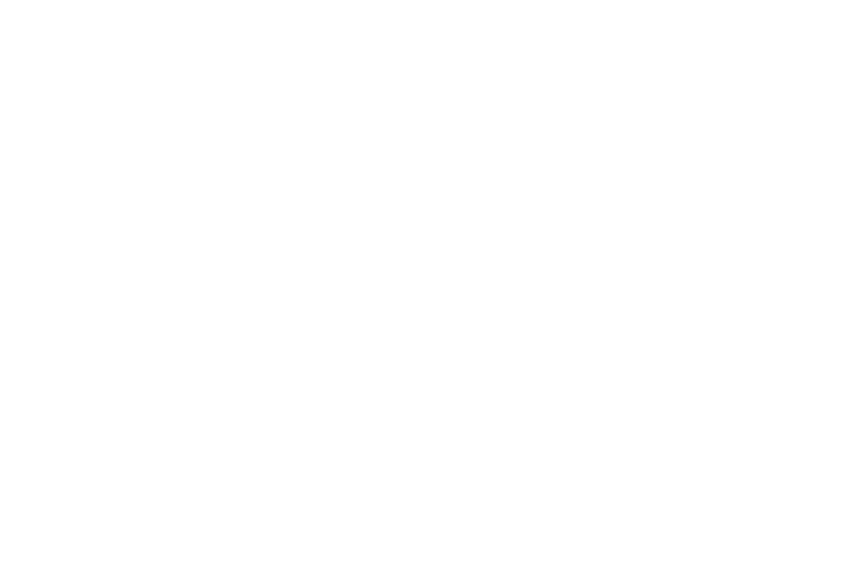

<IPython.core.display.Javascript object>


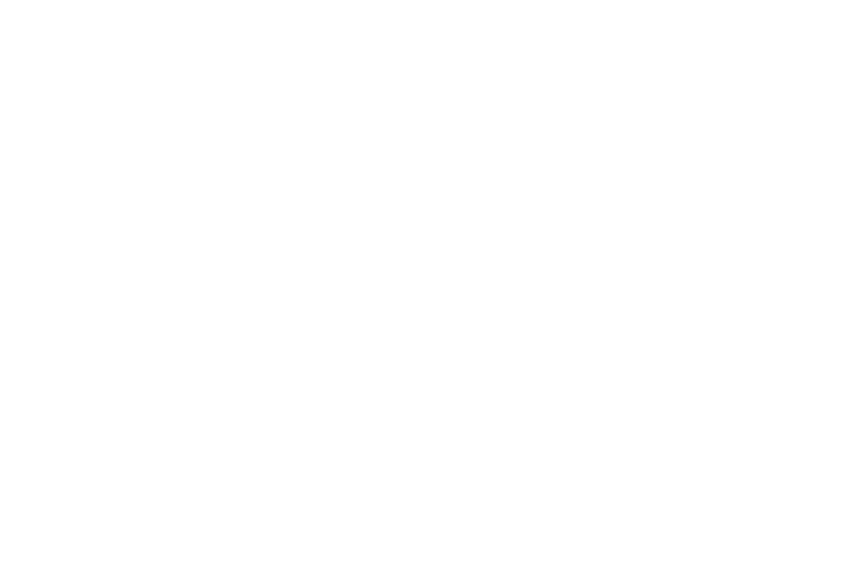

In [12]:
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xs[:,0], Xs[:,1], Xs[:,2])
xx = np.linspace(np.min(Xs), np.max(Xs), num=500)
plt.plot(W[0]*xx, W[1]*xx, W[1]*xx,  '--k')
plt.show()

## Part 4: Implementation of Oja's Rule in N-Dimensions

For good measure we generalize to N dimensions.

### Create a 3-dimensional dataset

In [13]:
N = 100
n_samples = 500
n_clouds = 2
centers = np.array([0, 15])

# Random seed
np.random.seed(1)

# Create a random data set made of two clouds of points in 3-space
X = np.zeros((n_samples, N))
X[0:int(n_samples/n_clouds), :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[0]
X[int(n_samples/n_clouds):, :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[1]

### Rescale

In [14]:
# Rescale to have zero mean and standard devation 1
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Evolve neuron according to Oja's Rule

In [15]:
# Generate initial weights
W = np.random.normal(scale=0.25, size=(N,1))
W_prev = np.ones((N,1))

# learning rate and tolerance of change in weights
eps = 1e-5
tol = 1e-9

# this implementation is one-to-one from the Bonaccorso (2017)
# it is very straightforward
while np.linalg.norm(W - W_prev) > tol:
    W_prev = W.copy()
    Y = np.dot(Xs, W)
    W += eps * np.sum(Y*Xs - np.square(Y)*W.T, axis=0).reshape((N,1))

### Now compare results with eigenvector of covariance matrix (1st principal component)

In [16]:
C = np.cov(Xs.T)
eigval, eigvec = np.linalg.eig(C)

etol = 1e-6 # error tolerance for discrepancy between weight vector and first pc

# show the eigenvector with the largest eigenvalue and the weight vector
print(eigvec[:,np.argmax(eigval)])
print(np.reshape(W, N))
print(eigvec[:,np.argmax(eigval)] - np.reshape(W, N) < etol)

[-0.10203116 -0.0990985  -0.09094662 -0.09469753 -0.09781945 -0.09867645
 -0.09660206 -0.10414626 -0.10019487 -0.09739357 -0.09714799 -0.10240135
 -0.10056604 -0.10437093 -0.10510164 -0.09905384 -0.09395701 -0.09413992
 -0.09514114 -0.10250614 -0.09914916 -0.1057761  -0.1003873  -0.09433545
 -0.1004125  -0.10493049 -0.0885165  -0.09805776 -0.10239991 -0.0957168
 -0.09413443 -0.09399821 -0.09840859 -0.09432036 -0.09778714 -0.1080309
 -0.10357855 -0.10842473 -0.10183078 -0.09640964 -0.10385302 -0.1049993
 -0.10534095 -0.0996028  -0.09689445 -0.1055391  -0.10309534 -0.09422196
 -0.0969262  -0.09687235 -0.1015128  -0.09844419 -0.09913276 -0.10066172
 -0.10265936 -0.10454023 -0.09335857 -0.1039336  -0.0972167  -0.09657659
 -0.09929644 -0.10373171 -0.09895196 -0.10153684 -0.09042446 -0.10700142
 -0.09780263 -0.10445638 -0.10136269 -0.09936402 -0.10632108 -0.10000769
 -0.09983589 -0.09953457 -0.10063706 -0.10876342 -0.10033391 -0.09793085
 -0.10270665 -0.08959574 -0.10555089 -0.10103214 -0.10

## Part 5: Extension to find all principal components (Sanger's Rule)

Oja's rule has been extended to include more than one neuron that sees the same input vector. Sanger's rule results in each of the neurons learning a different principal component.

$$ r^{out}_i := \sum_{j=1}^{N} w_{ij} x_j = \textbf{w}^T \textbf{x} .$$

$$\frac {dw_{ij}}{dt} = \eta ( r^{out}_i x_j - r^{out}_i \sum_{k=1}^{i}w_{kj} y_k).$$

### Create a 2-dimensional dataset

In [17]:
N = 2
n_samples = 500
n_clouds = 2
centers = np.array([0, 15])

# Random seed
np.random.seed(1)

# Create a random data set made of two clouds of points in 3-space
X = np.zeros((n_samples, N))
X[0:int(n_samples/n_clouds), :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[0]
X[int(n_samples/n_clouds):, :] = np.random.normal(0,10,(int(n_samples/n_clouds), N)) + centers[1]

### Rescale

In [18]:
# Rescale to have zero mean and standard devation 1
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Evolve neuron according to Oja's Rule

In [19]:
# Generate initial weights
W = np.random.normal(scale=0.25, size=(N,N))
W_prev = np.ones((N,N))

print(Xs)
print(W)
print(np.dot(Xs, W))

[[  6.76330732e-01  -1.13387312e+00]
 [ -1.08278939e+00  -1.50939368e+00]
 [  5.60975035e-02  -2.50969965e+00]
 [  7.74780527e-01  -1.25555622e+00]
 [ -3.90415964e-01  -8.38817161e-01]
 [  5.43744041e-01  -2.31315258e+00]
 [ -9.14638826e-01  -9.48477319e-01]
 [  2.75413142e-01  -1.53131419e+00]
 [ -7.92062026e-01  -1.35053428e+00]
 [ -6.16648331e-01  -1.61248801e-01]
 [ -1.55061553e+00   2.96259024e-01]
 [  8.56677232e-02  -2.26646332e-01]
 [  8.50672397e-02  -1.19247251e+00]
 [ -7.51577673e-01  -1.39768563e+00]
 [ -8.70075520e-01  -2.03961707e-01]
 [ -1.21639891e+00  -9.58817028e-01]
 [ -1.21273111e+00  -1.32394828e+00]
 [ -1.19971530e+00  -6.46090506e-01]
 [ -1.56425620e+00  -4.44916881e-01]
 [  7.05307409e-01  -3.16040461e-02]
 [ -8.07922457e-01  -1.35848949e+00]
 [ -1.26175365e+00   7.42223394e-01]
 [ -6.09624975e-01  -1.15442299e+00]
 [ -4.95123527e-01   1.07425599e+00]
 [ -5.52948498e-01  -1.33250058e-01]
 [ -4.05836256e-01  -9.22581979e-01]
 [ -1.58485703e+00  -9.20214989e-01]
 

In [20]:
# learning rate and tolerance of change in weights
#eps = 1e-5
#tol = 1e-9

# this implementation is one-to-one from the Bonaccorso (2017)
# it is very straightforward
#while np.linalg.norm(W - W_prev) > tol:
#    W_prev = W.copy()    
#    Y = np.dot(Xs, W)
#    # convert to vector form later
#    for i in range(N):
#        for j in range(n_samples):
#            W[i,] += eps * (Y[j,i] * Xs[j,i] - Y[j,i] * np.sum(W[0:i,:]*Y[j, 0:i]))

In [21]:
W_sanger = np.random.normal(scale=0.25, size=(2, 2))
prev_W_sanger = np.ones((2, 2))

learning_rate = 0.00025
tolerance = 1e-8

while np.linalg.norm(prev_W_sanger - W_sanger) > tolerance:
    prev_W_sanger = W_sanger.copy()
    dw = np.zeros((2, 2))
    
    for j in range(Xs.shape[0]):
        Ysj = np.dot(Xs[j], W_sanger).reshape((2, 1))
        QYd = np.tril(np.dot(Ysj, Ysj.T))
        dw += np.dot(Ysj, Xs[j].reshape((1, 2))) - np.dot(QYd, W_sanger)
        
    W_sanger += learning_rate * dw

### Now compare results with eigenvector of covariance matrix (1st principal component)

In [22]:
C = np.cov(Xs.T)
eigval, eigvec = np.linalg.eig(C)

print(eigvec)
print(W_sanger)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[-0.79780569 -0.65930359]
 [-0.55134855  0.79780572]]


### Plot this vector through the data

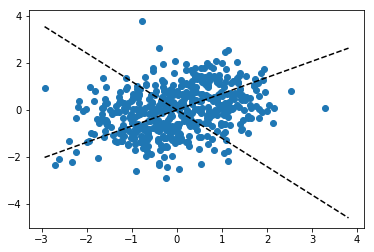

In [23]:
%matplotlib inline
# Plot the data
plt.figure()
plt.scatter(Xs[:,0], Xs[:,1])

# Plot the weight vector
xx = np.linspace(np.min(Xs), np.max(Xs), num=500)
plt.plot(xx, W_sanger[1,0]/W_sanger[0,0]*xx, '--k')
plt.plot(xx, W_sanger[1,1]/W_sanger[0,1]*xx, '--k')
plt.show()

## Open Questions

What happens if the first principal component is in the direction of one of the axes? Is there a problem?

## References

Bonaccorso, Giuseppe (2017, Aug 21). ML algorithms addendum: hebbian learning. Retrieved at: https://www.bonaccorso.eu/2017/08/21/ml-algorithms-addendum-hebbian-learning/

Oja, Erkki (1982). A simplified neuron model as a principal component analyzer. $\textit{Journal of Mathematical Biology}$, 15:267-2735. 

Oja, Erkki (2008). Oja learning rule, $\textit{Scholarpedia}$, 3(3):3612. Retrieved at: http://www.scholarpedia.org/article/Oja_learning_rule.